# OptOut Project Revision: Construct 14-year-long work sequences

For robustness check

In [1]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from operator import itemgetter
from datetime import datetime

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

/Users/xzhuo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Week-to-week crosswalk

Create two functions to convert between week number and calendar year and month

In [2]:
#this is the file to switch between week number in NLSY79 and calendar year, month, and day
xl_file = pd.ExcelFile('../data/continuous_week_crosswalk_2012.xlsx') 
weekdf = xl_file.parse('weekdates1')
weekdf.head()

,Week Start: Month,Week Start: Day,Week Start: Year,Calendar Year Week Number,Continuous Week Number
0,1,1,1978,1,1
1,1,8,1978,2,2
2,1,15,1978,3,3
3,1,22,1978,4,4
4,1,29,1978,5,5


In [3]:
def get_week_num(year, month, which, df=weekdf):
    """
    Given a calendar year and month, return the corresponding week number in NLSY79.
    
    If which=='first', return the first week in that month.
    If which=='last', return the last week in that month. 
    """
    
    the_month = weekdf[(weekdf['Week Start:\nMonth']==month)&(weekdf['Week Start: \nYear']==year)]
    
    if which == 'first':
        return int(the_month.iloc[0]['Continuous \nWeek Number'])
    elif which == 'last':
        return int(the_month.iloc[len(the_month)-1]['Continuous \nWeek Number'])

In [4]:
def get_year_month(weeknum, df=weekdf):
    """
    Given a week number, return the corresponding calendar month and year (yyyy, m).
    """
    
    the_week = weekdf[weekdf['Continuous \nWeek Number']==weeknum]
    return int(the_week.iloc[0]['Week Start: \nYear']), int(the_week.iloc[0]['Week Start:\nMonth'])

## Retrieve analytic sample

In [5]:
# get main 18-year-seq sample
monthly_df_main = pd.read_csv('../data/monthly_df.csv') 
monthly_df_main.head()

,id,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month207,month208,month209,month210,month211,month212,month213,month214,month215,month216
0,2,1993,4,5,1,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
1,3,1981,7,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
2,4,1980,9,4,4,4,4,4,4,4,...,3,3,3,3,3,3,3,0,0,0
3,8,1976,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
4,16,1990,3,1,1,5,5,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [6]:
# cut to 14-year (168 months)
monthly_df_main = monthly_df_main[['id', 'start_y', 'start_m']+['month%i'%i for i in range(1, 169)]]
monthly_df_main.head()

,id,start_y,start_m,month1,month2,month3,month4,month5,month6,month7,...,month159,month160,month161,month162,month163,month164,month165,month166,month167,month168
0,2,1993,4,5,1,4,4,4,4,4,...,3,3,3,3,3,3,3,3,3,3
1,3,1981,7,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2,4,1980,9,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
3,8,1976,4,4,4,4,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1
4,16,1990,3,1,1,5,5,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [7]:
analytic_df = pd.read_csv('../data/analytic_df_seq14.csv') #includes fertility data
print analytic_df.shape

# for the following sections, only look at the respondents who are not present in the 18-year-seq sample
analytic_df = analytic_df[(~analytic_df.caseid_1979.isin(monthly_df_main.id.values.tolist()))]
print analytic_df.shape

(3682, 37)
(248, 37)


## Read weekly arrays and within-job gap dates

In [8]:
#read weekly array data
wkarray_df = pd.read_csv('../data/weeklyarrays.csv')
print wkarray_df.shape
print wkarray_df.columns[:20]

(12686, 3969)
Index([u'caseid_1979', u'hrs_worked_wk_num0000_xrnd',
       u'hrs_worked_wk_num0001_xrnd', u'hrs_worked_wk_num0002_xrnd',
       u'hrs_worked_wk_num0003_xrnd', u'hrs_worked_wk_num0004_xrnd',
       u'hrs_worked_wk_num0005_xrnd', u'hrs_worked_wk_num0006_xrnd',
       u'hrs_worked_wk_num0007_xrnd', u'hrs_worked_wk_num0008_xrnd',
       u'hrs_worked_wk_num0009_xrnd', u'hrs_worked_wk_num0010_xrnd',
       u'hrs_worked_wk_num0011_xrnd', u'hrs_worked_wk_num0012_xrnd',
       u'hrs_worked_wk_num0013_xrnd', u'hrs_worked_wk_num0014_xrnd',
       u'hrs_worked_wk_num0015_xrnd', u'hrs_worked_wk_num0016_xrnd',
       u'hrs_worked_wk_num0017_xrnd', u'hrs_worked_wk_num0018_xrnd'],
      dtype='object')


In [9]:
#read within-job-gap data
gap_df = pd.read_csv("../data/withingaps.csv")
print gap_df.shape
print gap_df.columns[:20]

(12686, 839)
Index([u'caseid_1979', u'per1_start_1979_job01_xrnd',
       u'per1_start_1979_job02_xrnd', u'per1_start_1979_job03_xrnd',
       u'per1_start_1979_job04_xrnd', u'per1_start_1979_job05_xrnd',
       u'per1_stop_1979_job01_xrnd', u'per1_stop_1979_job02_xrnd',
       u'per1_stop_1979_job03_xrnd', u'per1_stop_1979_job04_xrnd',
       u'per1_stop_1979_job05_xrnd', u'per2_start_1979_job01_xrnd',
       u'per2_start_1979_job02_xrnd', u'per2_start_1979_job03_xrnd',
       u'per2_start_1979_job04_xrnd', u'per2_start_1979_job05_xrnd',
       u'per2_stop_1979_job01_xrnd', u'per2_stop_1979_job02_xrnd',
       u'per2_stop_1979_job03_xrnd', u'per2_stop_1979_job04_xrnd'],
      dtype='object')


## Identify maternity leaves

Maternity leave could cover the birth, start after the birth, or end before the birth. 

Let's assume any within-job gap that start or end within 4 months (16 weeks) of birth as maternity leave. Record the types of maternity leave: 

* 100 - gap covered birth, 
* (100+n) - gap started within n weeks after birth, 
* (100-n) - gap ended within n weeks before birth. 

There are relatively fewer maternity gaps that finished within 16 weeks before birth, so do not consider within-job gaps that ended within 16 weeks before birth as maternity leave.

### Does any of our respondents have gaps that started/ended prior to 1/1/1978? 

NO

In [10]:
merged = analytic_df.merge(gap_df, on='caseid_1979') # merge datasets
merged.columns

Index([u'caseid_1979', u'sample_id_1979', u'sample_race_1979',
       u'sample_sex_1979', u'c1dob_m_xrnd', u'c1dob_y_xrnd', u'c2dob_m_xrnd',
       u'c2dob_y_xrnd', u'c3dob_m_xrnd', u'c3dob_y_xrnd',
       ...
       u'per3_start_2014_job03_xrnd', u'per3_start_2014_job04_xrnd',
       u'per3_stop_2014_job01_xrnd', u'per3_stop_2014_job02_xrnd',
       u'per3_stop_2014_job03_xrnd', u'per3_stop_2014_job04_xrnd',
       u'per4_start_2014_job01_xrnd', u'per4_start_2014_job02_xrnd',
       u'per4_stop_2014_job01_xrnd', u'per4_stop_2014_job02_xrnd'],
      dtype='object', length=875)

In [11]:
# count how many zero values in each job gap column
# NONE

for col in merged.columns.tolist():
    if col.startswith('per'): # only check job gap columns
        count = sum(merged[col]==0)
        if count > 0:
            print col, count

### Write a function to retrieve all valid job gap start and end weeks

Get pct missing in gap dates

In [14]:
# revised the function in 2seq_construction to do only counting 

counts = defaultdict(list)

def get_gaps(row):
    """
    Given a row of respondent data, 
    Return a list of tuples (start week, end week) of work gaps for respondent i
    """
    
    gap_row = gap_df[gap_df.caseid_1979==row['caseid_1979']].iloc[0]
    years = range(1979, 1995)+range(1996, 2015, 2)
    
    #look for within-job gaps in all years. sometimes the gaps were recorded in later years
    for y in years: 
        for j in range(1, 5): #4 possible gap periods
            for k in range(1, 6): #5 possible jobs
                try: 
                    gap_start = gap_row['per%s_start_%s_job0%s_xrnd'%(j, y, k)]
                    gap_stop = gap_row['per%s_stop_%s_job0%s_xrnd'%(j, y, k)]
                    
                    if gap_start >= 0 and gap_stop >= 0: # valid, no missing
                        counts['valid dates'].append(row['caseid_1979'])
                    elif gap_start == -4 and gap_stop == -4: # valid skip
                        counts['valid skips'].append(row['caseid_1979'])
                    else:
                        counts['missing'].append(row['caseid_1979'])
                      
                except KeyError: # some years do not report 5 jobs
                    pass


gaps = analytic_df.apply(get_gaps, axis=1)

In [16]:
### calculate pct missing

# total number of missing gaps / total number of gaps
total_missing = len(counts['missing'])
total = len(counts['valid dates'] + counts['missing'])
print total_missing, total, float(total_missing)/total

27 1137 0.023746701847


In [17]:
# total number of respondents with missing / total number of respondents
total_missing = len(set(counts['missing']))
total = analytic_df.shape[0]
print total_missing, total, float(total_missing)/total

23 248 0.0927419354839


### Write a function to determine weeks of maternity leave - DISREGARD ALL MISSING GAPS

In [19]:
###modify to handle months prior to 1978


def get_gaps(row):
    """
    Given a row of respondent data, 
    Return a list of tuples (start week, end week) of work gaps for respondent i
    
    COPY THE SAME FUNCTION AS ABOVE, EXCEPT: COMMENT OUT THE PART THAT HANDLES MISSING CASES
    """
    
    gap_row = gap_df[gap_df.caseid_1979==row['caseid_1979']].iloc[0]
    gaps = []
    
    years = range(1979, 1995)+range(1996, 2015, 2)
    
    #look for within-job gaps in all years. sometimes the gaps were recorded in later years
    for y in years: 
        for j in range(1, 5): #4 possible gap periods
            for k in range(1, 6): #5 possible jobs
                try: 
                    gap_start = gap_row['per%s_start_%s_job0%s_xrnd'%(j, y, k)]
                    gap_stop = gap_row['per%s_stop_%s_job0%s_xrnd'%(j, y, k)]
                    
                    if gap_start >= 0 and gap_stop >= 0: # valid, no missing
                        gaps.append((gap_start, gap_stop))
#                    elif gap_start == -4 and gap_stop == -4: # valid skip
#                        pass # valid skip
#                    else:
#                        pass
#                         missing_data['caseid_1979'].append(row['caseid_1979'])
#                         missing_data['start_col'].append('per%s_start_%s_job0%s_xrnd'%(j, y, k))
#                         missing_data['start'].append(gap_start) 
                        
#                         start_y = None
#                         start_m = None
#                         if gap_start > 0:
#                             start_y, start_m = get_year_month(gap_start)
#                         missing_data['start_y'].append(start_y)
#                         missing_data['start_m'].append(start_m)

#                         missing_data['end_col'].append('per%s_stop_%s_job0%s_xrnd'%(j, y, k))
#                         missing_data['end'].append(gap_stop)
                        
#                         end_y = None
#                         end_m = None
#                         if gap_stop > 0:
#                             end_y, end_m = get_year_month(gap_stop)
#                         missing_data['end_y'].append(end_y)
#                         missing_data['end_m'].append(end_m)

#                         print 'missing data - id:', row['caseid_1979'], 'year:', y, 'gap #:', j, 'job #:', k, 'weeks: ', (gap_start, gap_stop)
                        
                except KeyError: # some years do not report 5 jobs
                    pass
                
    return gaps


def find_maternal_leave_no_before(row):
    """
    Given a row of respondent data, return a list of all weeks identified as maternal leaves
    """
    
    leaves = [] # store all weeks that are part of maternity leaves
    
    gaps = get_gaps(row)
    
    for j in range(1, 12): # all births
        dob_y = row['c%idob_y_xrnd'%j]
        dob_m = row['c%idob_m_xrnd'%j]
        
        if dob_y>0 and dob_m>0:
            
            # note: job gap dates do not go prior to 1978 
            # (we do not count the three cases with dates prior to 1/1/1978, as explained above)
            
            if dob_y >= 1978: 
                
                for (gap_start, gap_stop) in gaps:
                    birth_wks = range(get_week_num(dob_y, dob_m, 'first'), get_week_num(dob_y, dob_m, 'last')+1)
                    gap_wks = range(gap_start, gap_stop+1)
                    is_ma_leave = False

                    if set(birth_wks)&set(gap_wks): #the gap overlaps with the birth
                        is_ma_leave = True

                    elif gap_start>birth_wks[-1] and gap_start-birth_wks[-1]<=16: #gap started within 16 weeks after birth
                        is_ma_leave = True

                    if is_ma_leave:
                        leaves += range(gap_start, gap_stop+1) # store all weeks that are maternity leaves
    
    return leaves

## Tranform weekly sequences

My status classification scheme:

* 1 - full-time employment
* 2 - working with missing hours
* 3 - part-time employent [**NEW: treat working with hour 0 as part-time**]
* 4 - nonwokring 
* 5 - maternity leave


NEW: If respondents reported working 0 hours in week 0 (total hours worked pre-1978), assign 4-nonworking to all weeks before week 1. 

In [20]:
#select only week array data for our selected sample
merged_wkarray_df = analytic_df.merge(wkarray_df, on='caseid_1979')
print merged_wkarray_df.shape

(248, 4005)


In [21]:
# Create a dictionary to store data
data = defaultdict(list)

# count how many hours people work with employment status 3 (associated with employer)
count_hrs_status3 = []

for i, row in merged_wkarray_df.iterrows(): #iterate through weekly array rows

    #keep track of progress
    if i%100 == 0: 
        print i
    
    #find year and month of first childbirth
    dob_y = row['c1dob_y_xrnd']
    dob_m = row['c1dob_m_xrnd']
    
    #find employment sequence start year and month
    if dob_m == 12:
        start_y = dob_y+1
        start_m = 1
    else:
        start_y = dob_y
        start_m = dob_m+1
    
    
    #keep three columns: id, start_y, start_m
    data['id'].append(row['caseid_1979'])
    data['start_y'].append(start_y)
    data['start_m'].append(start_m) 
        
    #maternal leaves
    leaves = find_maternal_leave_no_before(row)
        
    for week_num in range(1, 1880): #iterate through all weekly work variables
         
        #if the week is maternity leave
        if week_num in leaves:
            data['week%s'%week_num].append(5) 
            continue
        
        #otherwise:
        my_status = None
        
        #get the hours worked this week 
        hours = row['hrs_worked_wk_num%04d_xrnd'%week_num]
    
        #get the employment status this week
        status = row['status_wk_num%04d_xrnd'%week_num]

        if (status >= 100 and status <= 2615):
            status = 'w' #working
        
        if hours >= 35:
            hours = 'ft' #full-time working hours
        elif hours > 0 and hours < 35:
            hours = 'pt' #part-time working hours
        
        
        ### define employment status according to my classification scheme ###
        
        # missing
        if hours == 0 and status == 0:
            my_status = 0
            
        # full time
        elif hours == 'ft' and status in ['w', 3]:
            my_status = 1
        elif hours == 0 and status == 7:
            my_status = 1
            
        # working, missing hours
        elif hours <= 0 and status in ['w', 3]: 
            my_status = 2
            
            ###################
            if status==3:
                count_hrs_status3.append(hours)
            ###################
            
        # part time
        elif hours == 'pt' and status in ['w', 3]:
            my_status = 3

        ####### NEW #######
        elif hours == 0 and status == 'w':
            my_status = 3
        ###################                
            
        # non-working
        elif hours <= 0 and status in [2, 4, 5]:
            my_status = 4
        elif hours == 'pt' and status in [4, 5]: # strange
            print (hours, status)
            my_status = 4

        else:
            raise Exception, 'unknown hours and status: (%s, %s)'%(hours, status)
            
        data['week%s'%week_num].append(my_status) #make the week number start from 0, easier for indexing in Python

0
('pt', 5)
100
200


In [22]:
#create the new weekly array dataframe with my edited employment status

#week number range: 1 - 1879

#order the columns in the new dataframe
cols = ['id', 'start_y', 'start_m'] + ['week%s'%n for n in range(1, 1880)]

full_df = pd.DataFrame(data, columns=cols)
print full_df.iloc[0]

id            46
start_y     1994
start_m        5
week1          4
week2          4
week3          4
week4          4
week5          4
week6          4
week7          4
week8          4
week9          4
week10         4
week11         4
week12         4
week13         4
week14         4
week15         4
week16         4
week17         4
week18         4
week19         4
week20         4
week21         4
week22         4
week23         4
week24         4
week25         4
week26         4
week27         4
            ... 
week1850       0
week1851       0
week1852       0
week1853       0
week1854       0
week1855       0
week1856       0
week1857       0
week1858       0
week1859       0
week1860       0
week1861       0
week1862       0
week1863       0
week1864       0
week1865       0
week1866       0
week1867       0
week1868       0
week1869       0
week1870       0
week1871       0
week1872       0
week1873       0
week1874       0
week1875       0
week1876       0
week1877      

In [23]:
#how many times did status 3 appear?
print len(count_hrs_status3)

175


In [24]:
#what work hours are associated with status 3?
set(count_hrs_status3)

{-3, 0}

In [25]:
# export to csv
#full_df.to_csv('../data/full_wk_df_seq14.csv', index=False)

## Construct 14-year monthly sequences

In [26]:
def find_modal(l):
    """
    Given a list l, return the most common element in the list. 
    if there is a tie, return all elements.
    """
    
    #first, count frequency of each unique item in the list
    counter = defaultdict(int)
    for item in l:
        counter[item] += 1

    #rank items from most frequent to least frequent
    popular_items = sorted(counter, key=counter.get, reverse = True)
    
    most_common = [popular_items[0]]
    
    for other in popular_items[1:]:
        if counter[other] < counter[most_common[0]]:
            break
        elif counter[other] == counter[most_common[0]]: #find an equally frequent item
            most_common.append(other)
        else:
            print 'impossible'

    return most_common

#for example
print find_modal([1, 1, 2, 1, 5])
print find_modal([1, 1, 2, 1, 5, 2, 2, 33])

[1]
[1, 2]


In [27]:
import random
random.seed(7222014)

res_data = defaultdict(list) #create an empty dictionary to store data

count_ties = [] #how many we get ties of modal

for i, row in full_df.iterrows():
    
    # keep track of progress
    if i%100 == 0:
        print i
    
    # keep basic info: id, sequence start year and month
    res_data['id'].append(row['id'])
    
    y = row['start_y']
    m = row['start_m']
    
    res_data['start_y'].append(y)
    res_data['start_m'].append(m)
    
    
    # look at weekly statuses
    for j in range(1, 169): # from month 1 to month 168, 14 years
        
        if y < 1978: #prior to 1978
            hrs_pre1978 = merged_wkarray_df[merged_wkarray_df.caseid_1979==row['id']].iloc[0]['hrs_worked_wk_num0000_xrnd']
            
            if hrs_pre1978 == 0: # never worked before 1978
                res_data['month%s'%j].append(4) # assign 4 - nonemployed
            else:
                res_data['month%s'%j].append(0) # otherwise, assign missing
            
        else:
            start = get_week_num(y, m, 'first')
            end = get_week_num(y, m, 'last')
            wk_statuses = [row['week%i'%k] for k in range(start, end+1)]

            #find unique items in the given month 
            distinct = list(set(wk_statuses))
            distinct.sort()

            if len(distinct) == 1:
                res_data['month%s'%j].append(distinct[0])

            elif len(distinct) >= 2:
                modal = find_modal(wk_statuses)
                if len(modal) == 1:
                    res_data['month%s'%j].append(modal[0])
                else:
                    res_data['month%s'%j].append(random.choice(modal))
                    count_ties.append(row['id'])

         
        #move to next month
        if m < 12:
            m += 1
        elif m == 12:
            m = 1
            y += 1

cols = ['id', 'start_y', 'start_m'] + ['month%s'%i for i in range(1, 169)]
res_df = pd.DataFrame(res_data, columns=cols) 

0
100
200


In [28]:
print "%s instances of ties"%len(count_ties)
print "%s unique respondents have ties"%len(set(count_ties))

236 instances of ties
113 unique respondents have ties


# Output dataset

In [29]:
print res_df.shape
res_df = pd.concat([monthly_df_main, res_df])
print res_df.shape

(248, 171)
(3682, 171)


In [30]:
#export to csv
res_df.to_csv("../data/monthly_df_seq14.csv", index=False)

# Explore the sequences

In [33]:
def count_status_per_R(row, s):
    """
    Count the frequency of status s appearing in each respondent's sequence
    """
    
    vals = [row['month%s'%i]==s for i in range(1, 169)] # 14 years, 168 months
    return sum(vals)

### status 0 - missing

In [34]:
freq0 = res_df.apply(lambda row: count_status_per_R(row, 0), axis=1)
print "%s respondents have no missing"%sum([v==0 for v in freq0])

3283 respondents have no missing


mean: 14.0526315789, median: 10.0


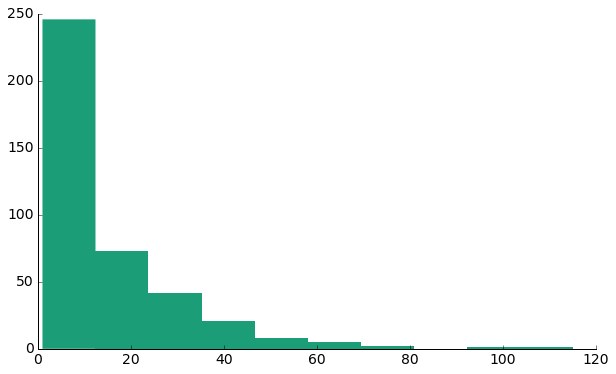

In [35]:
# drop respondents who have no missing
freq0_wo_zero = [v for v in freq0 if v>0]

# mean and median of missing months per respondent
print 'mean: %s, median: %s'%(np.mean(freq0_wo_zero), np.median(freq0_wo_zero))

# plot histogram
plt.hist(freq0_wo_zero)
remove_border()

### status 2 - working, with missing hours

In [36]:
freq2 = res_df.apply(lambda row: count_status_per_R(row, 2), axis=1)
print "%s respondents have no month working with missing hours"%sum([v==0 for v in freq2])

3410 respondents have no month working with missing hours


mean: 11.3308823529, median: 8.5


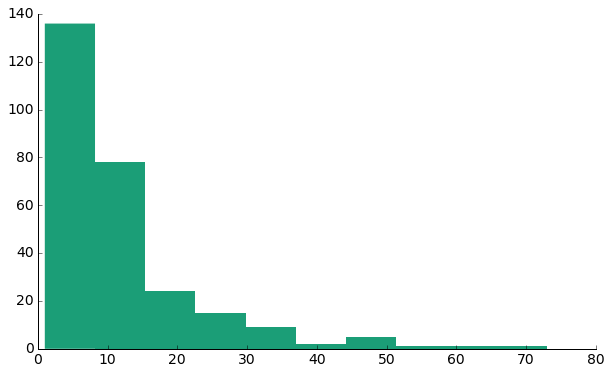

In [37]:
# drop respondents who have no month working with missing hours
freq2_wo_zero = [v for v in freq2 if v>0]

# mean and median of missing months per respondent
print 'mean: %s, median: %s'%(np.mean(freq2_wo_zero), np.median(freq2_wo_zero))

# plot histogram
plt.hist(freq2_wo_zero)
remove_border()